## Import thư viện

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Attention, Concatenate, TimeDistributed, RepeatVector, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [196]:
def load_data(file_path):
    # Tải dữ liệu từ file CSV
    df = pd.read_csv(file_path)
    
    print("Thông tin cơ bản về DataFrame:")
    df_info = df.info()
    print(df_info)

    print("\nSố lượng giá trị thiếu trong mỗi cột:")
    missing_values = df.isnull().sum()
    print(missing_values)

    # Kiểm tra trùng lặp trong cột 'title'
    dupes = df[df.duplicated(subset='title', keep=False)]
    print(f"- Số dòng có title trùng: {dupes.shape[0]}")
    print(dupes[['title']].drop_duplicates())

    print('- Số dòng riêng biệt:')
    title_counts = df['title'].value_counts()
    duplicates = title_counts[title_counts > 1]
    print(f'{duplicates} \n')
    
    return df

In [197]:
def clean_data(df):
    # Loại bỏ các dòng trùng lặp theo cột 'title'
    df = df.drop_duplicates(subset='title', keep='first')
    
    dupes = df[df.duplicated(subset='title', keep=False)]
    print(f"- Số dòng trùng lặp sau khi xử lý: {dupes.shape[0]}")

    print('- Shape: ', df.shape)

    # Loại bỏ các cột không cần thiết
    columns_to_drop = ['backdrop_path', 'homepage', 'imdb_id', 'original_language', 
                       'original_title', 'overview', 'popularity', 'poster_path', 
                       'tagline', 'production_companies', 'production_countries', 
                       'spoken_languages', 'keywords', 'title']
    df.drop(columns=columns_to_drop, inplace=True)

    print(df.info())

    # Xử lý giá trị thiếu
    df['status'] = df['status'].fillna('Unknown')
    df['genres'] = df['genres'].fillna('Unknown')

    # Chuyển đổi cột 'release_date' thành kiểu datetime
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

    print(df[['status', 'genres', 'release_date']].isnull().sum())

    # Tách cột 'genres' thành danh sách
    df.loc[:, 'genres_list'] = df['genres'].str.split(',')
    df.drop(columns=['genres'], inplace=True)

    # Thêm các cột 'year' và 'month'
    df.loc[:, 'year'] = pd.to_datetime(df['release_date']).dt.year
    df['month'] = df['release_date'].dt.month

    # Chỉ giữ các phim từ thế kỷ 20 (1900-1999)
    df = df[((df['year'] >= 1900) & (df['year'] <= 1999))]

    # Kiểm tra lại dữ liệu sau khi xử lý
    print(df[['year', 'release_date']].isnull().sum())

    return df

In [198]:
# Tải dữ liệu
file_path = '/kaggle/input/tmdb-movies-dataset-2023-930k-movies/TMDB_movie_dataset_v11.csv'
df = load_data(file_path)

# Làm sạch dữ liệu
df_cleaned = clean_data(df)

# Kiểm tra kết quả
print(df_cleaned.head())

Thông tin cơ bản về DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217219 entries, 0 to 1217218
Data columns (total 24 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1217219 non-null  int64  
 1   title                 1217206 non-null  object 
 2   vote_average          1217219 non-null  float64
 3   vote_count            1217219 non-null  int64  
 4   status                1217219 non-null  object 
 5   release_date          995376 non-null   object 
 6   revenue               1217219 non-null  int64  
 7   runtime               1217219 non-null  int64  
 8   adult                 1217219 non-null  bool   
 9   backdrop_path         316711 non-null   object 
 10  budget                1217219 non-null  int64  
 11  homepage              127815 non-null   object 
 12  imdb_id               621375 non-null   object 
 13  original_language     1217219 non-null  object 
 14  ori

/tmp/ipykernel_31/757785060.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)


<class 'pandas.core.frame.DataFrame'>
Index: 1041028 entries, 0 to 1217218
Data columns (total 10 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   id            1041028 non-null  int64  
 1   vote_average  1041028 non-null  float64
 2   vote_count    1041028 non-null  int64  
 3   status        1041028 non-null  object 
 4   release_date  853363 non-null   object 
 5   revenue       1041028 non-null  int64  
 6   runtime       1041028 non-null  int64  
 7   adult         1041028 non-null  bool   
 8   budget        1041028 non-null  int64  
 9   genres        606931 non-null   object 
dtypes: bool(1), float64(1), int64(5), object(3)
memory usage: 80.4+ MB
None


/tmp/ipykernel_31/757785060.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status'] = df['status'].fillna('Unknown')
/tmp/ipykernel_31/757785060.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genres'] = df['genres'].fillna('Unknown')
/tmp/ipykernel_31/757785060.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

status               0
genres               0
release_date    187665
dtype: int64


/tmp/ipykernel_31/757785060.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'genres_list'] = df['genres'].str.split(',')
/tmp/ipykernel_31/757785060.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['genres'], inplace=True)
/tmp/ipykernel_31/757785060.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

year            0
release_date    0
dtype: int64
     id  vote_average  vote_count    status release_date    revenue  runtime  \
7   550         8.438       27238  Released   1999-10-15  100853753      139   
9   680         8.488       25893  Released   1994-09-10  213900000      154   
10   13         8.477       25409  Released   1994-06-23  677387716      142   
14  278         8.702       24649  Released   1994-09-23   28341469      142   
16  603         8.206       23815  Released   1999-03-30  463517383      136   

    adult    budget                 genres_list    year  month  
7   False  63000000                     [Drama]  1999.0   10.0  
9   False   8500000          [Thriller,  Crime]  1994.0    9.0  
10  False  55000000  [Comedy,  Drama,  Romance]  1994.0    6.0  
14  False  25000000             [Drama,  Crime]  1994.0    9.0  
16  False  63000000  [Action,  Science Fiction]  1999.0    3.0  


In [199]:
def plot_status_distribution(df):
    # Phân tích và vẽ biểu đồ số lượng phim theo trạng thái phát hành
    status_counts = df['status'].value_counts()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=status_counts.index, y=status_counts.values, palette='pastel')

    for i, value in enumerate(status_counts.values):
        plt.text(i, value + 100, str(value), ha='center', va='bottom')

    plt.title('Số lượng phim theo trạng thái phát hành (status)')
    plt.xlabel('Trạng thái phát hành (status)')
    plt.ylabel('Số lượng phim')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

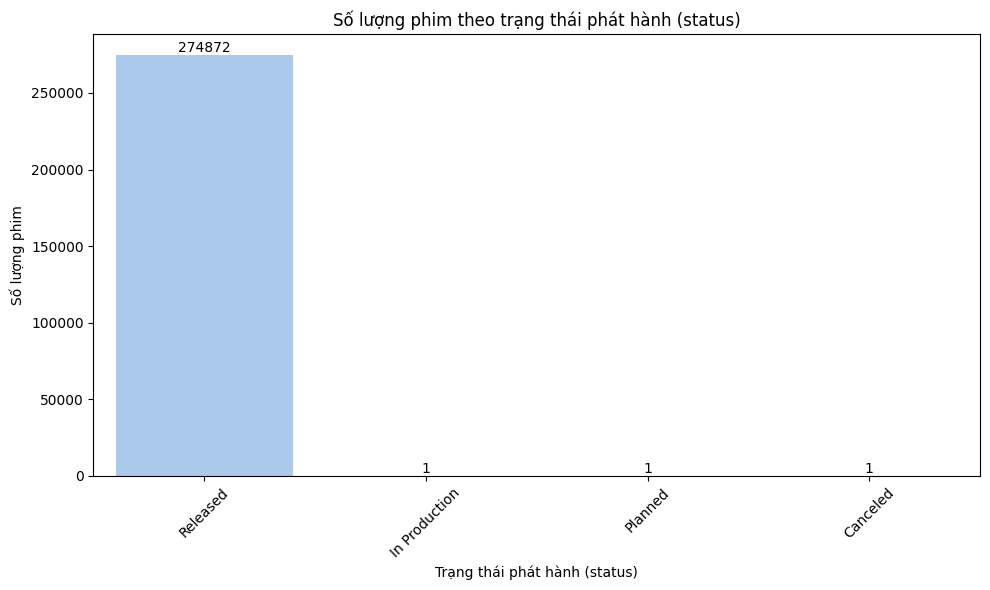

In [200]:
plot_status_distribution(df_cleaned)

In [201]:
def analyze_votes(df):
    # Lọc các phim đã phát hành
    df = df[df['status'] == 'Released']

    df_votes = df[(df['vote_average'] != 0) & (df['vote_count'] != 0)].copy()

    max_vote_average = df_votes['vote_average'].max()
    min_vote_average = df_votes['vote_average'].min()

    print(f"Giá trị max của vote_average: {max_vote_average}")
    print(f"Giá trị min của vote_average: {min_vote_average}")

    # Phân phối điểm đánh giá
    plt.figure(figsize=(10, 6))
    sns.histplot(df_votes['vote_average'].dropna(), bins=20, kde=True, color='skyblue')
    plt.title('Phân phối điểm đánh giá (vote_average)')
    plt.xlabel('Điểm đánh giá')
    plt.ylabel('Số lượng phim')
    plt.grid(True)
    plt.show()

    # Mối quan hệ giữa vote_count và vote_average
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_votes, x='vote_count', y='vote_average', alpha=0.6)
    plt.xscale('log')
    plt.title('Vote Average vs. Vote Count (log scale)')
    plt.xlabel('Vote Count (log scale)')
    plt.ylabel('Vote Average')
    plt.grid(True)
    plt.show()

Giá trị max của vote_average: 10.0
Giá trị min của vote_average: 0.5


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


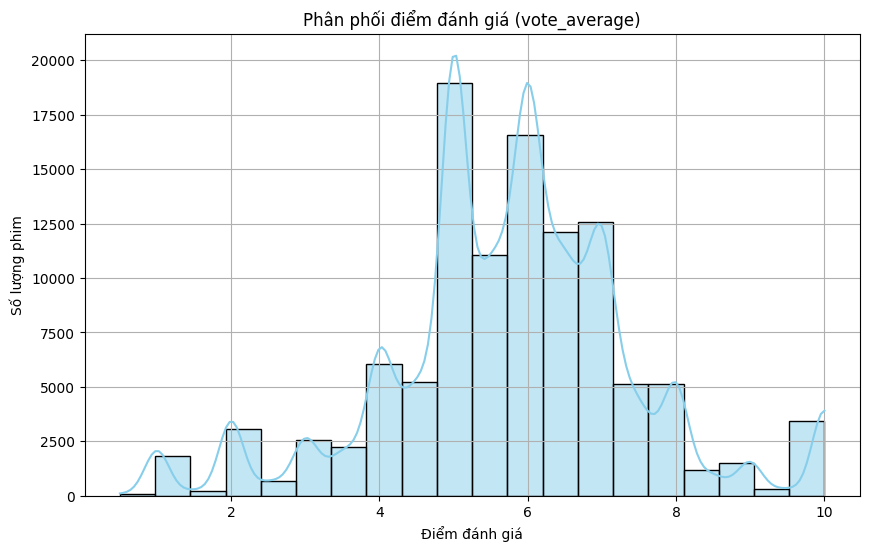

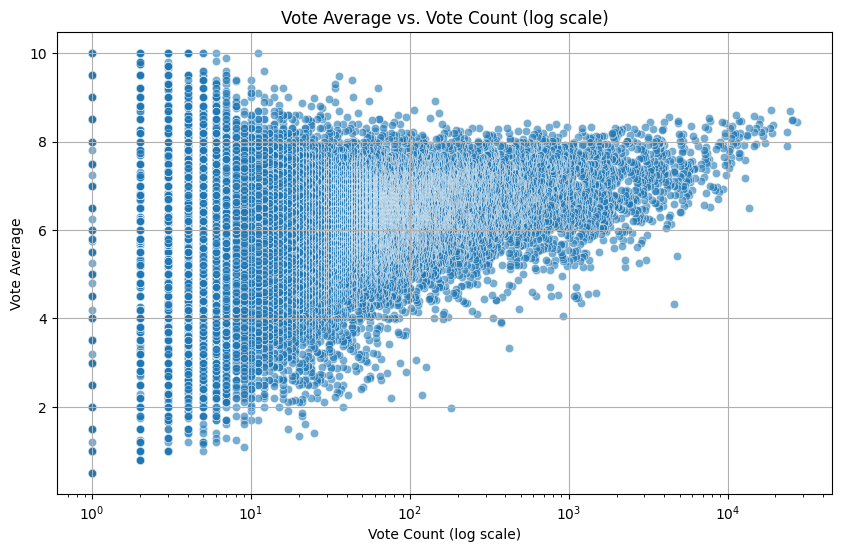

In [202]:
analyze_votes(df_cleaned)

In [203]:
def analyze_runtime(df):
    # Lọc thời gian phim hợp lệ (từ 1 đến 300 phút)
    df_runtime_filtered = df[df['runtime'].between(1, 300)]

    # Phân phối thời gian phim
    plt.figure(figsize=(10, 6))
    sns.histplot(df_runtime_filtered['runtime'], bins=50, kde=True, color='skyblue')
    plt.title('Phân phối thời lượng phim (runtime)')
    plt.xlabel('Thời lượng (phút)')
    plt.ylabel('Số lượng phim')
    plt.grid(True)
    plt.show()

    # Xu hướng thời gian trung bình theo năm
    runtime_by_year = df_runtime_filtered.groupby('year')['runtime'].mean()

    plt.figure(figsize=(12,6))
    runtime_by_year.plot(kind='line', marker='o', color='darkblue', linewidth=2, markersize=8)
    plt.title('Runtime trung bình theo năm', fontsize=14, fontweight='bold', color='darkblue')
    plt.xlabel('Năm', fontsize=12, color='g')
    plt.ylabel('Runtime trung bình (phút)', fontsize=12, color='darkgreen')
    plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


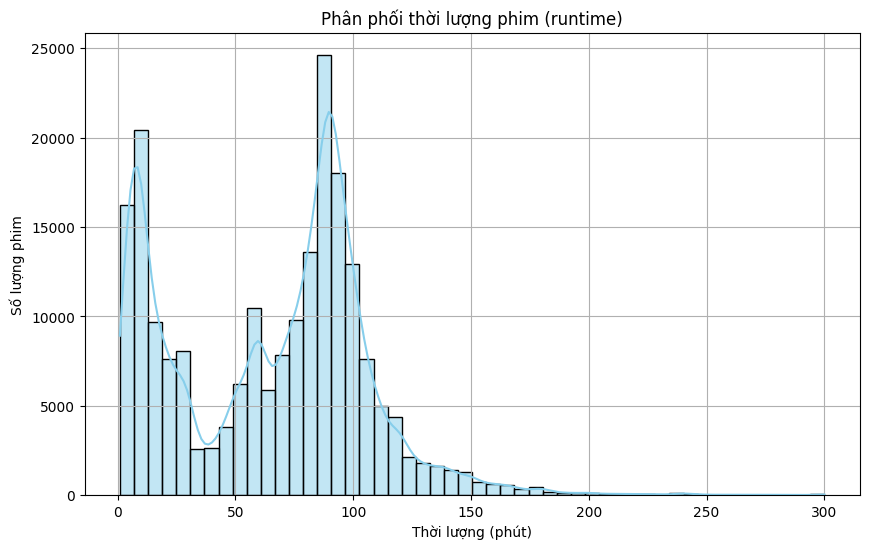

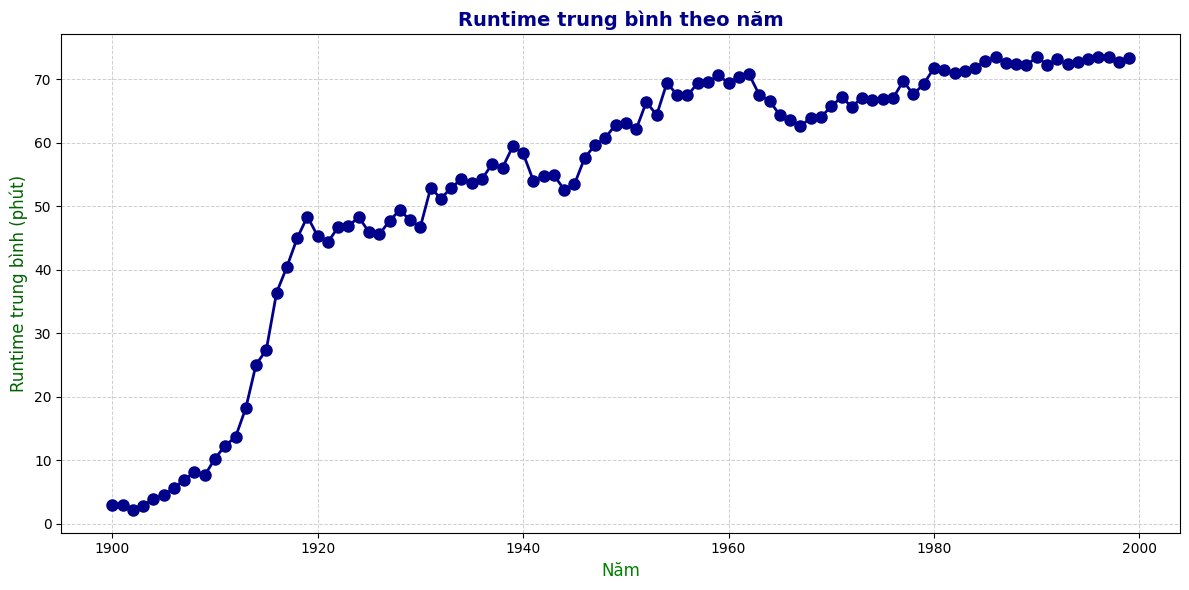

In [204]:
analyze_runtime(df_cleaned)

In [205]:
def analyze_genres(df):
    # Lọc phim không có giá trị Unknown trong genres
    df['genres_list'] = df['genres_list'].apply(
        lambda genres: [g.strip().title() for g in genres]
    )
    df_genres_filtered = df[df['genres_list'].apply(lambda x: 'Unknown' not in x)]

    # Phân tích số lượng phim theo thể loại qua các năm
    genres_by_year = df_genres_filtered.explode('genres_list').groupby(['year', 'genres_list']).size().unstack().fillna(0)

    top_5_genres = genres_by_year.sum().sort_values(ascending=False).head(5).index
    genres_by_year_top5 = genres_by_year[top_5_genres]

    plt.figure(figsize=(12,8))
    plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.5)
    for genre, color in zip(top_5_genres, sns.color_palette("Blues", len(top_5_genres))[::-1]):
        plt.plot(genres_by_year_top5.index, genres_by_year_top5[genre], label=genre, marker='o', markersize=6, color=color, linewidth=2)
    plt.xticks(rotation=45)
    plt.title('Top 5 Thể loại phổ biến theo năm', fontsize=16, fontweight='bold', color='darkblue')
    plt.xlabel('Năm', fontsize=12, color='darkgreen')
    plt.ylabel('Số lượng phim', fontsize=12, color='darkgreen')
    plt.legend(title='Thể loại', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()

    # Phân tích thời gian trung bình theo thể loại
    genres_runtime = df_genres_filtered.explode('genres_list').groupby('genres_list')['runtime'].mean()
    top_genres = genres_runtime.sort_values(ascending=False).head(20)

    plt.figure(figsize=(12, 7))
    ax = sns.barplot(x=top_genres.values, y=top_genres.index, palette="viridis")
    for i, v in enumerate(top_genres.values):
        ax.text(v + 1, i, f"{v:.1f}", va='center', fontweight='bold', fontsize=9)
    plt.title(f'Top 20 thể loại có thời lượng trung bình cao nhất', fontsize=14, fontweight='bold')
    plt.xlabel('Runtime trung bình (phút)')
    plt.ylabel('Thể loại')
    plt.tight_layout()
    plt.show()

    # Phân tích điểm đánh giá trung bình theo thể loại
    df_genres_filtered_vote = df_genres_filtered[df_genres_filtered['vote_count'] > 0]
    genres_vote_avg = df_genres_filtered_vote.explode('genres_list').groupby('genres_list')['vote_average'].mean()
    top_vote_avg = genres_vote_avg.sort_values(ascending=False).head(20)

    plt.figure(figsize=(12, 7))
    ax = sns.barplot(x=top_vote_avg.values, y=top_vote_avg.index, palette="crest")
    for i, v in enumerate(top_vote_avg.values):
        ax.text(v + 0.05, i, f"{v:.2f}", va='center', fontweight='bold', fontsize=9, color='black')
    plt.title(f'So sánh vote_average theo thể loại (Top 20)', fontsize=14, fontweight='bold')
    plt.xlabel('Vote Average')
    plt.ylabel('Thể loại')
    plt.tight_layout()
    plt.show()

    # Phân tích doanh thu theo thể loại
    df_genres_filtered.loc[:, 'revenue'] = df_genres_filtered['revenue'].fillna(0)
    genres_revenue = df_genres_filtered.explode('genres_list').groupby('genres_list')['revenue'].sum()
    top_revenue = genres_revenue.sort_values(ascending=False).head(20)

    plt.figure(figsize=(12, 7))
    ax = sns.barplot(x=top_revenue.values, y=top_revenue.index, palette="viridis")
    for i, v in enumerate(top_revenue.values):
        ax.text(v + 1e9, i, f"{v:,.0f}", va='center', fontweight='bold', fontsize=9, color='black')
    plt.title(f'Doanh thu (revenue) theo thể loại (Top 20)', fontsize=14, fontweight='bold')
    plt.xlabel('Doanh thu (USD)', fontsize=12)
    plt.ylabel('Thể loại', fontsize=12)
    plt.tight_layout()
    plt.show()

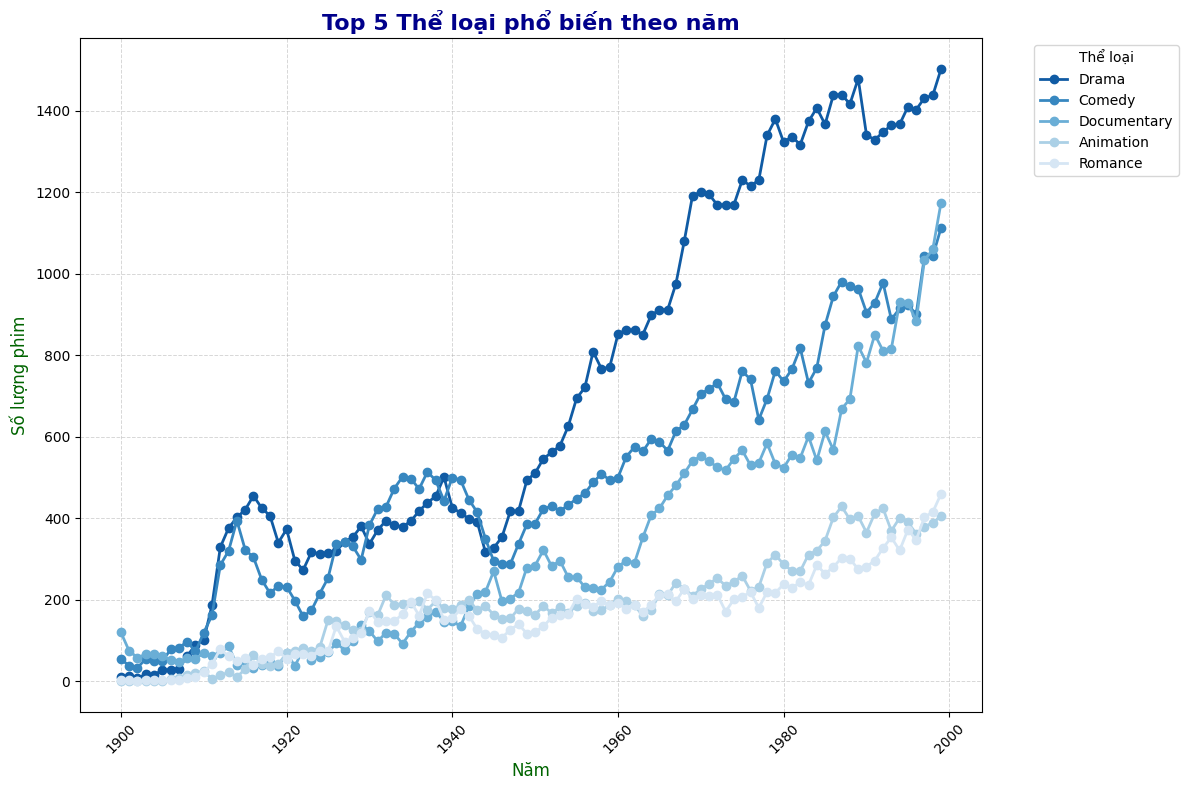

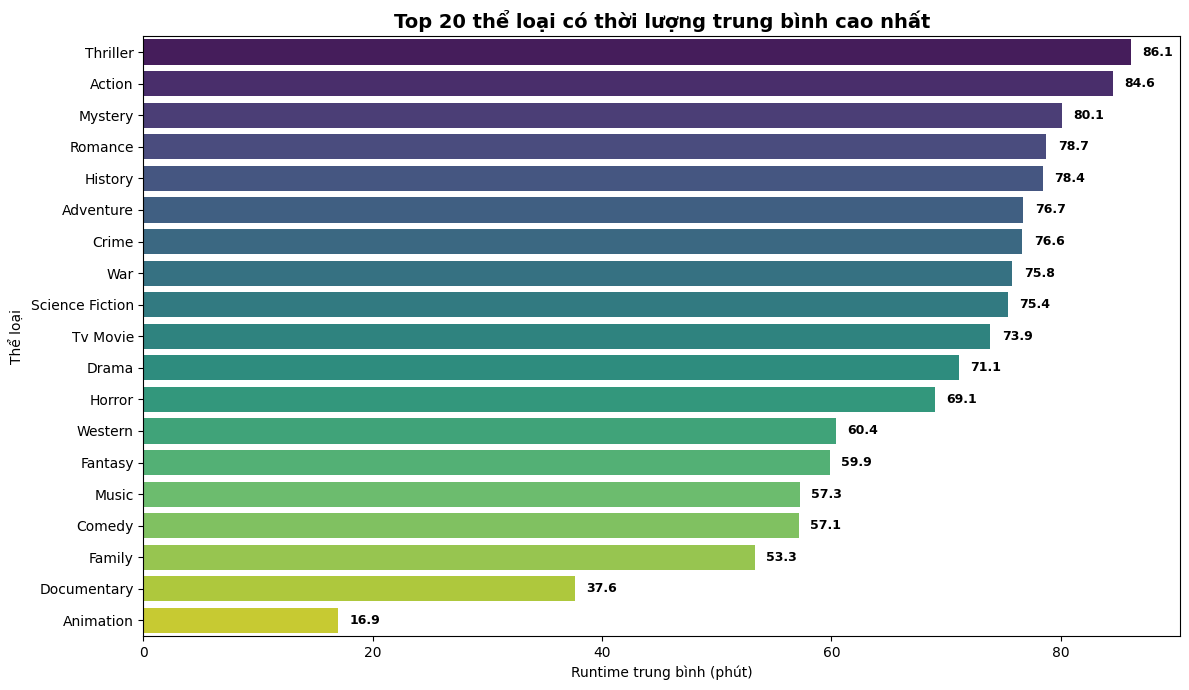

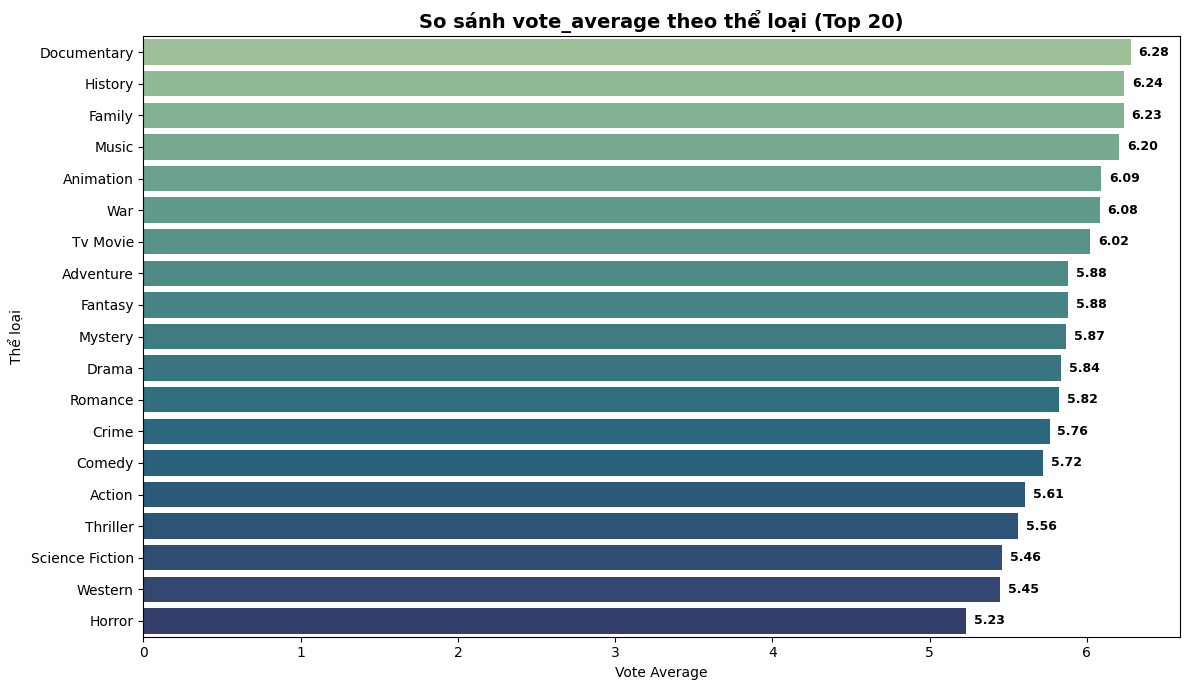

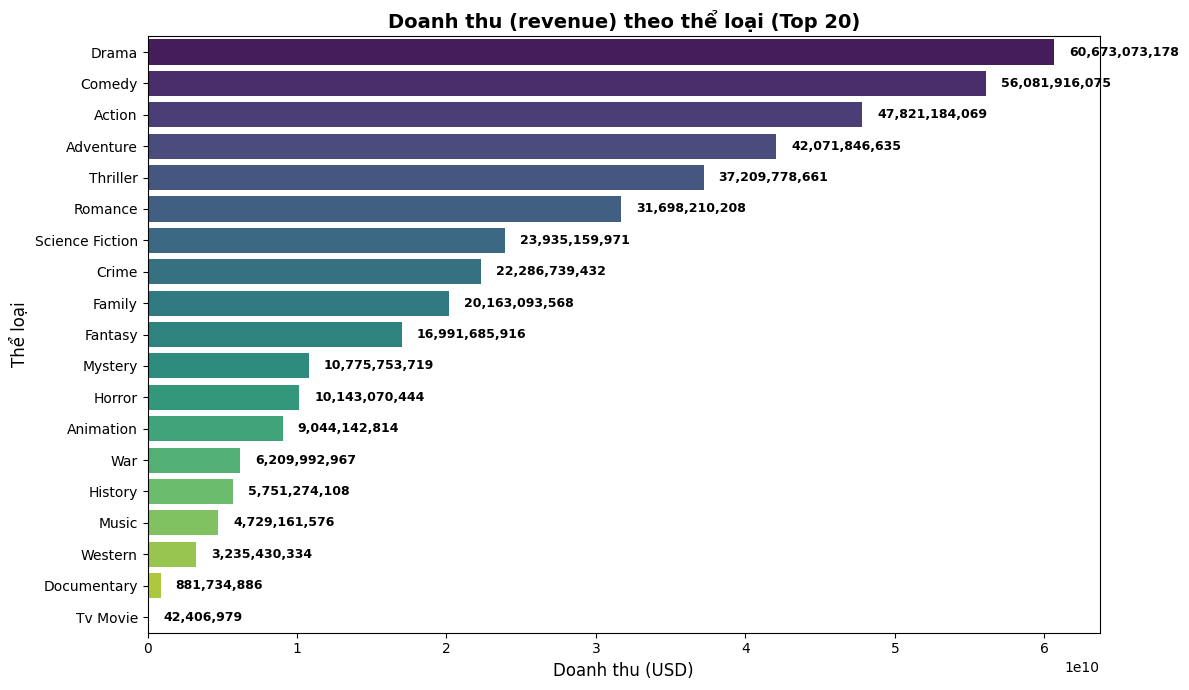

In [206]:
analyze_genres(df_cleaned)

In [207]:
def plot_movies_per_year(df):
    movies_per_year = df['year'].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    plt.plot(movies_per_year.index, movies_per_year.values, 
             color='deepskyblue', linewidth=2, marker='o', markerfacecolor='dodgerblue', markersize=7, markeredgewidth=2, markeredgecolor='steelblue')

    plt.gca().set_facecolor('aliceblue')
    plt.title('Số lượng phim phát hành mỗi năm', fontsize=16, fontweight='bold', color='midnightblue')
    plt.xlabel('Năm', fontsize=14, color='navy')
    plt.ylabel('Số lượng phim', fontsize=14, color='navy')

    plt.grid(True, linestyle='--', alpha=0.6, color='lightblue')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.show()

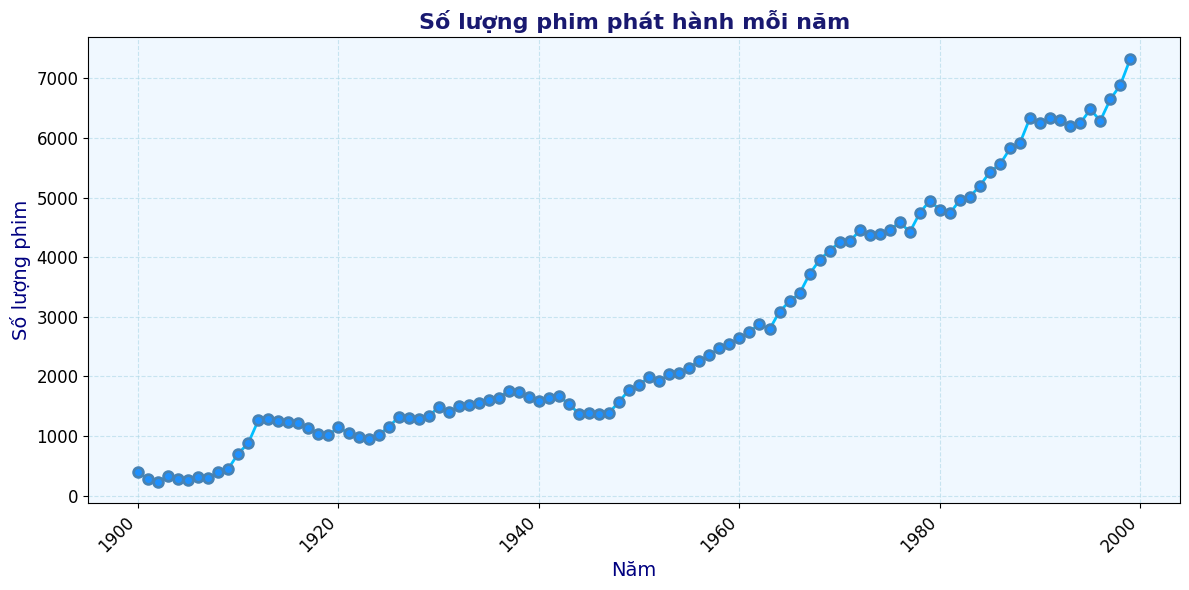

In [208]:
plot_movies_per_year(df_cleaned)

In [209]:
def plot_movies_per_month(df):
    df_filtered = df[df['release_date'].notna()]
    df_filtered['release_month'] = df_filtered['release_date'].dt.month

    movies_per_month = df_filtered['release_month'].value_counts().sort_index()

    plt.figure(figsize=(12, 6))

    colors = sns.color_palette("cool", len(movies_per_month))
    movies_per_month.plot(kind='bar', color=colors)

    plt.title('Mùa phát hành phổ biến (Số lượng phim phát hành mỗi tháng)', fontsize=16, fontweight='bold', color='midnightblue')
    plt.xlabel('Tháng', fontsize=14, color='navy')
    plt.ylabel('Số lượng phim', fontsize=14, color='navy')

    plt.xticks(ticks=np.arange(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45, fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.6, color='lightblue')
    plt.gca().set_facecolor('aliceblue')

    plt.tight_layout()
    plt.show()

In [210]:
def plot_movies_per_month_exclude_jan1(df):
    df_filtered = df[df['release_date'].notna()].copy()
    
    # Loại bỏ các phim phát hành ngày 1/1
    jan1_mask = ~((df_filtered['release_date'].dt.month == 1) & (df_filtered['release_date'].dt.day == 1))
    df_filtered = df_filtered[jan1_mask]
    
    df_filtered['release_month'] = df_filtered['release_date'].dt.month
    movies_per_month = df_filtered['release_month'].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    colors = sns.color_palette("cool", len(movies_per_month))
    movies_per_month.plot(kind='bar', color=colors)

    plt.title('Mùa phát hành (Loại bỏ phim phát hành ngày 1/1)', fontsize=16, fontweight='bold', color='darkred')
    plt.xlabel('Tháng', fontsize=14, color='maroon')
    plt.ylabel('Số lượng phim', fontsize=14, color='maroon')

    plt.xticks(ticks=np.arange(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6, color='salmon')
    plt.gca().set_facecolor('seashell')
    plt.tight_layout()
    plt.show()

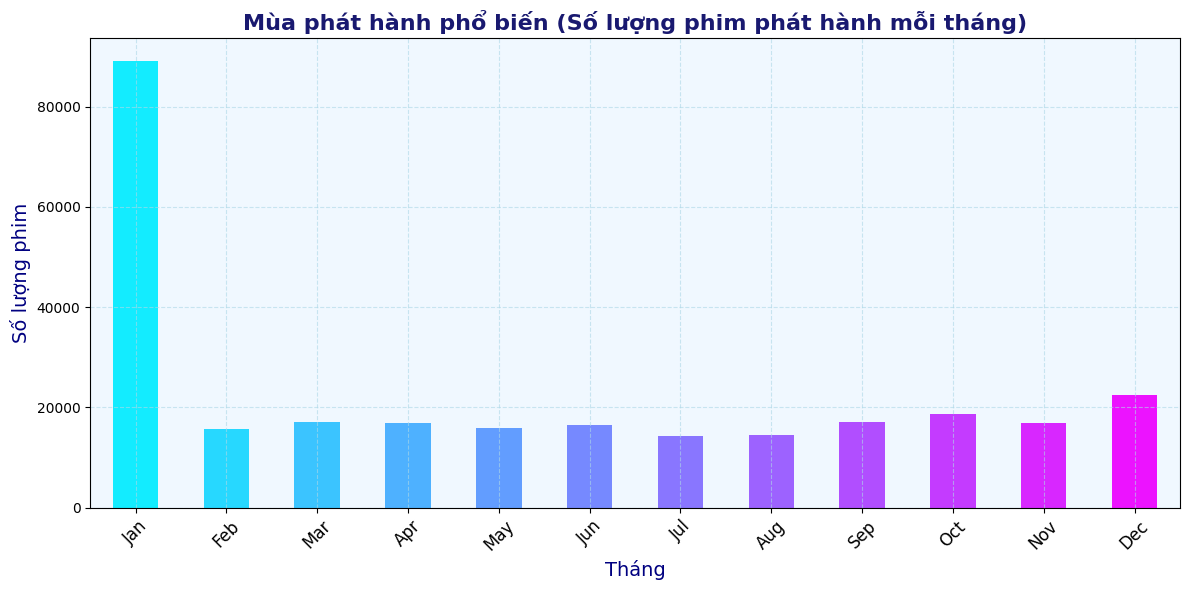

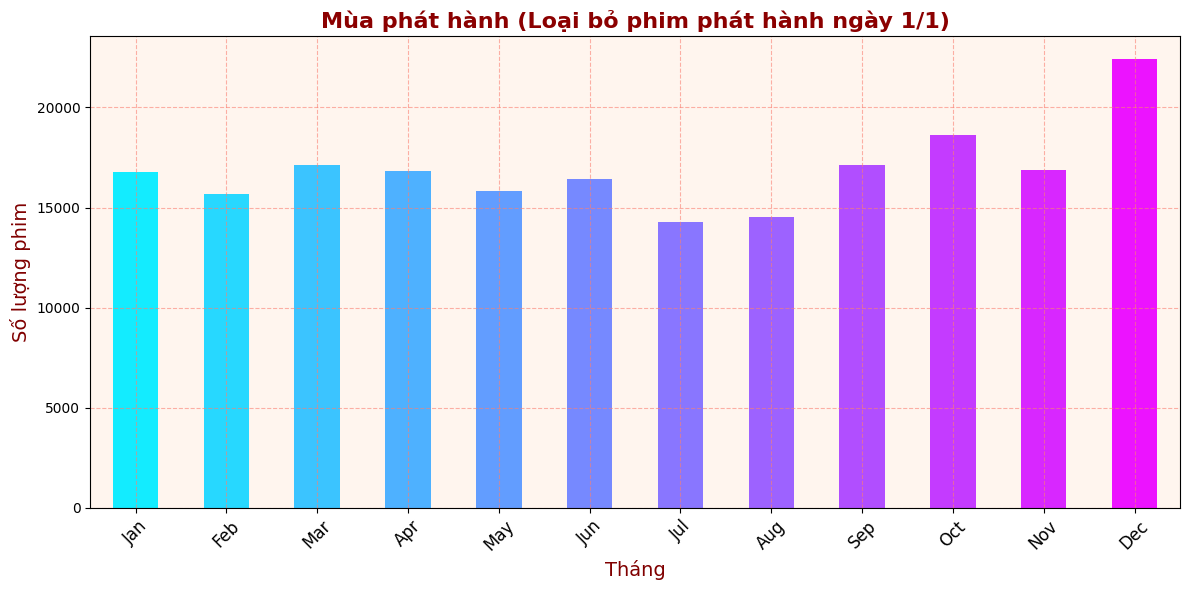

In [211]:
plot_movies_per_month(df_cleaned)
plot_movies_per_month_exclude_jan1(df_cleaned)

In [212]:
def plot_adult_movies_per_year(df):
    adult_movies_per_year = df[df['adult'] == True].groupby('year')['adult'].count()

    plt.figure(figsize=(12,6))

    plt.plot(adult_movies_per_year.index, adult_movies_per_year.values, 
             color='darkred', marker='o', markersize=8, linewidth=2, linestyle='-', alpha=0.7)

    plt.title('Xu hướng phát hành phim người lớn (adult) theo năm', fontsize=16, fontweight='bold', color='darkred')
    plt.xlabel('Năm', fontsize=14, color='darkblue')
    plt.ylabel('Số lượng phim người lớn', fontsize=14, color='darkblue')

    plt.grid(True, linestyle='--', alpha=0.5, color='lightgrey')
    plt.gca().set_facecolor('lavenderblush')

    plt.tight_layout()
    plt.show()

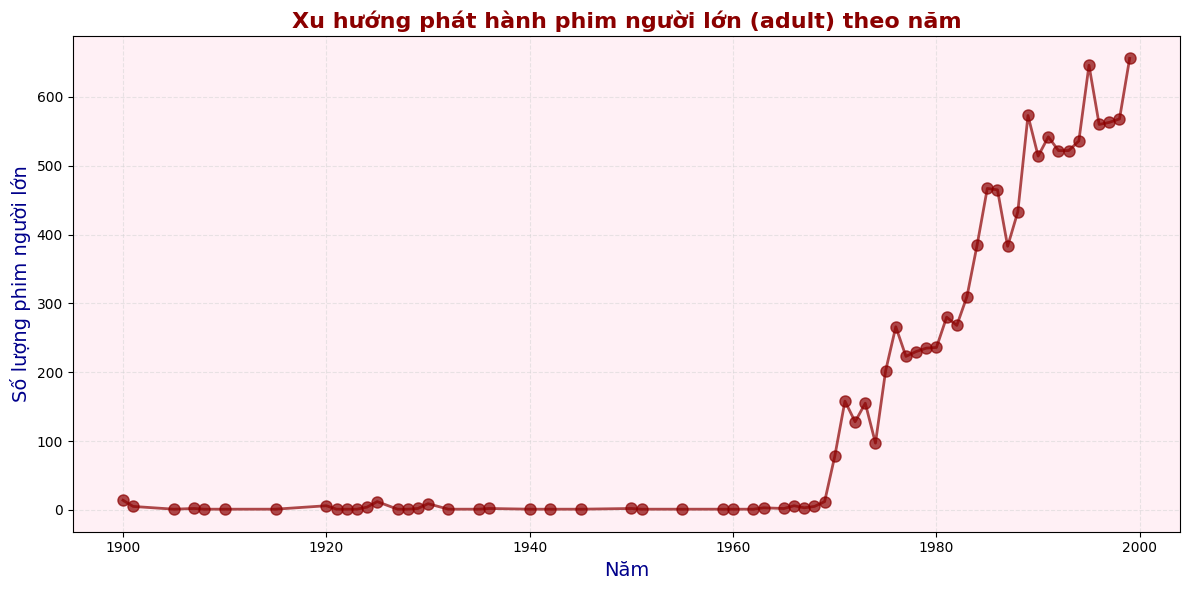

In [213]:
plot_adult_movies_per_year(df_cleaned)

In [214]:
def plot_financial_trends(df):
    # Loại bỏ phim không có dữ liệu tài chính
    df_finance = df[~((df['budget'] == 0) & (df['revenue'] == 0))].copy()
    df_finance['profit'] = df_finance['revenue'] - df_finance['budget']
    df_finance.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Trung bình theo năm
    df_money_by_year = df_finance.groupby('year')[['budget', 'revenue', 'profit']].mean()

    # --- Biểu đồ 1: Budget & Revenue ---
    colors = sns.color_palette("coolwarm", 2)
    plt.figure(figsize=(14, 6))
    df_money_by_year[['budget', 'revenue']].plot(marker='o', color=colors, linewidth=2)
    plt.title('Kinh phí và Doanh thu trung bình theo năm', fontsize=16, fontweight='bold')
    plt.xlabel('Năm', fontsize=13)
    plt.ylabel('USD', fontsize=13)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(['Kinh phí (Budget)', 'Doanh thu (Revenue)'], fontsize=12)
    plt.gca().set_facecolor('whitesmoke')
    plt.tight_layout()
    plt.show()

    # --- Biểu đồ 2: Profit trung bình theo năm ---
    plt.figure(figsize=(14, 6))
    df_money_by_year['profit'].plot(marker='o', color='seagreen', linewidth=2)
    plt.title('Lợi nhuận trung bình theo năm', fontsize=16, fontweight='bold')
    plt.xlabel('Năm', fontsize=13)
    plt.ylabel('Profit (USD)', fontsize=13)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_facecolor('honeydew')
    plt.tight_layout()
    plt.show()


<Figure size 1400x600 with 0 Axes>

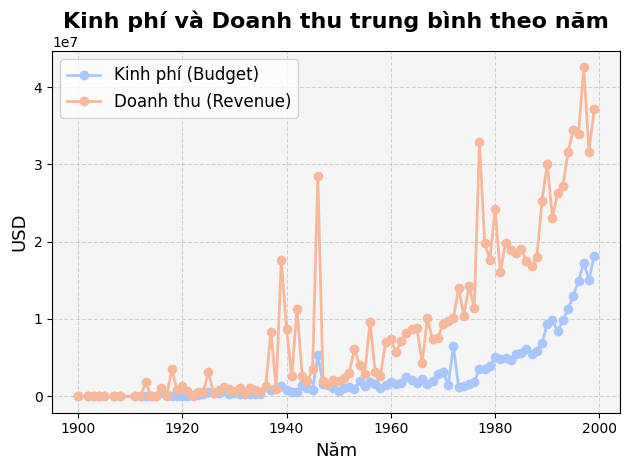

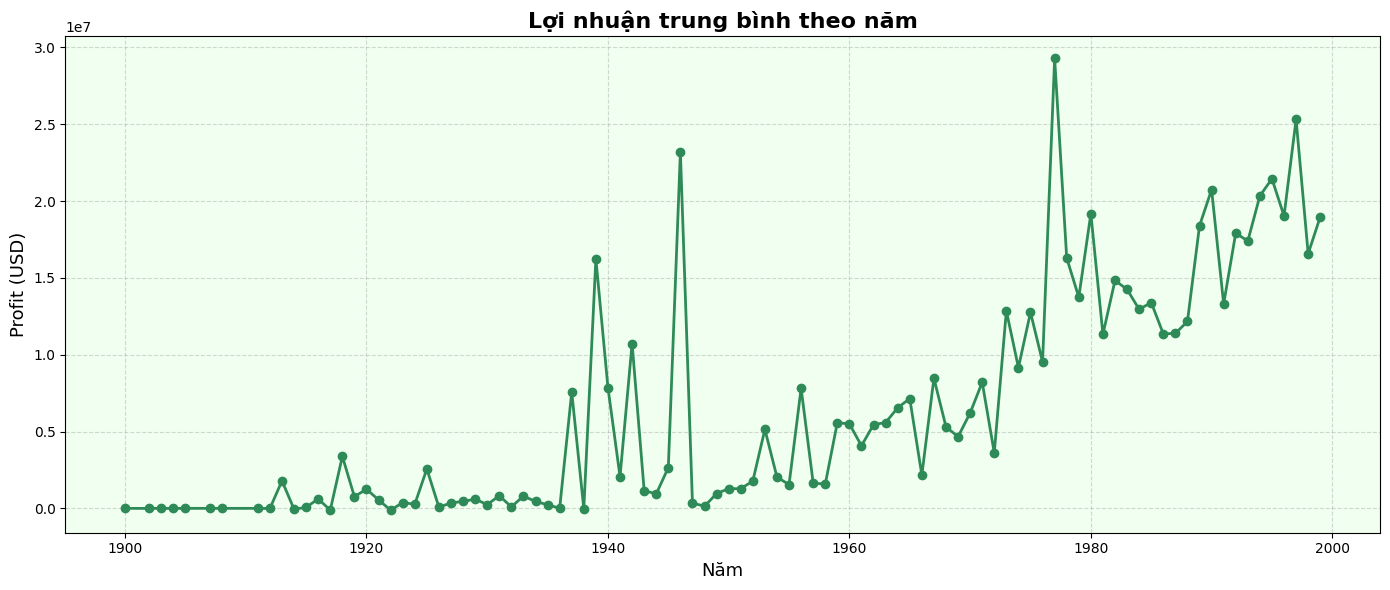

In [215]:
plot_financial_trends(df_cleaned)

# HERE


In [232]:
def clean_and_extract_data(df):
    # Chỉ giữ cột cần thiết
    cols = ['release_date','budget','revenue','runtime','vote_average','title']
    df = df[cols].copy()
    
    # Release_date -> datetime, lấy year
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    df = df.dropna(subset=['release_date'])
    df['year'] = df['release_date'].dt.year
    
    # Lọc năm 1900–2025
    df = df[(df['year']>=1900)&(df['year']<=2025)]
    
    # Xử lý giá trị
    df = df[(df['budget']>=0)&(df['revenue']>=0)&(df['runtime']>=0)]
    df['vote_average'] = df['vote_average'].fillna(df['vote_average'].mean())
    
    # movies_count
    df['movies_count'] = df.groupby('year')['title'].transform('count')
    
    # Loại bỏ dùng dằng
    df.drop(columns=['release_date','title'], inplace=True)
    print("After clean:", df.info())
    return df

In [233]:
# Giả sử df là DataFrame chứa dữ liệu ban đầu
df_cleaned = clean_and_extract_data(df)
print(df_cleaned.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 993056 entries, 0 to 1217218
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   budget        993056 non-null  int64  
 1   revenue       993056 non-null  int64  
 2   runtime       993056 non-null  int64  
 3   vote_average  993056 non-null  float64
 4   year          993056 non-null  int32  
 5   movies_count  993056 non-null  int64  
dtypes: float64(1), int32(1), int64(4)
memory usage: 49.2 MB
After clean: None
      budget     revenue  runtime  vote_average  year  movies_count
0  160000000   825532764      148         8.364  2010         20830
1  165000000   701729206      169         8.417  2014         28982
2  185000000  1004558444      152         8.512  2008         18998
3  237000000  2923706026      162         7.573  2009         19968
4  220000000  1518815515      143         7.710  2012         24548
5   58000000   783100000      108         7.606  2016  

In [234]:
def group_by_year(df):
    df_grouped = df.groupby('year').agg({
        'budget':'mean',
        'revenue':'mean',
        'runtime':'mean',
        'vote_average':'mean',
        'movies_count':'mean'
    }).reset_index()
    print("After group:\n", df_grouped.head())
    return df_grouped

In [235]:
df_grouped = group_by_year(df_cleaned)

After group:
    year     budget  revenue   runtime  vote_average  movies_count
0  1900   0.002347      0.0  2.450704      2.666599         426.0
1  1901   0.000000      0.0  2.759717      3.135205         283.0
2  1902  25.147059      0.0  2.193277      2.780525         238.0
3  1903   0.423729      0.0  2.502825      2.956695         354.0
4  1904  25.510204      0.0  3.846939      3.104728         294.0


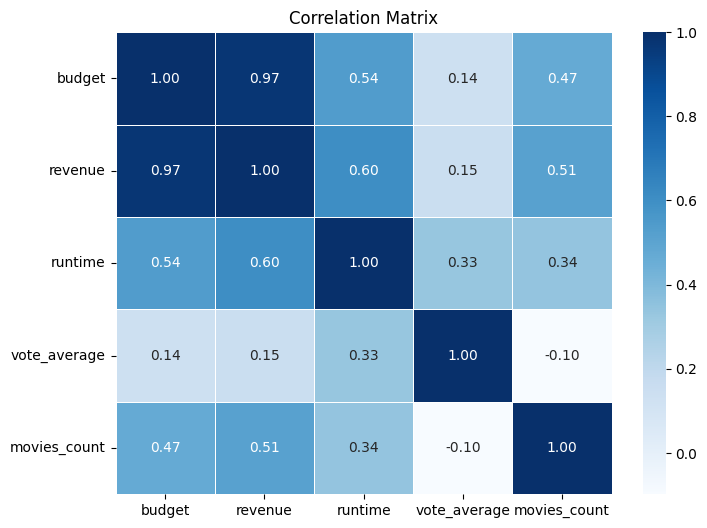

Dropping high-corr columns (> 0.9): {'budget'}


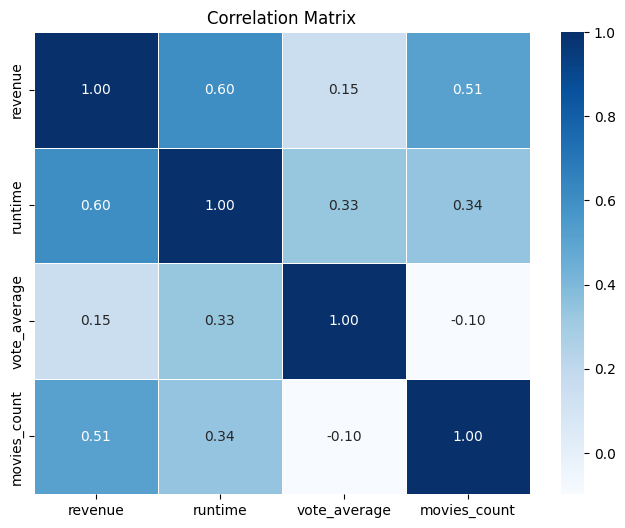

In [237]:
def analyze_correlation(df):
    corr = df.drop(columns=['year']).corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

# 4. Loại bỏ feature tương quan cao
def remove_high_correlation(df, threshold=0.9):
    corr = df.drop(columns=['year']).corr().abs()
    # Tìm cột có corr > threshold với bất kỳ cột nào khác
    to_drop = set()
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            if corr.iloc[i,j] > threshold:
                # đánh dấu drop cột j
                to_drop.add(corr.columns[i])
    print(f"Dropping high-corr columns (> {threshold}):", to_drop)
    return df.drop(columns=list(to_drop))

analyze_correlation(df_grouped)
# Gọi hàm để loại bỏ cột có tương quan cao
df_grouped_cleaned = remove_high_correlation(df_grouped)
# Gọi hàm phân tích tương quan sau khi đã loại bỏ cột tương quan cao
analyze_correlation(df_grouped_cleaned)

In [261]:
def train_predict_evaluate_lstm(df_grouped, look_back=5, epochs=50):
    # split
    train = df_grouped[(df_grouped['year']>=1900)&(df_grouped['year']<2000)]
    test  = df_grouped[(df_grouped['year']>=2000)&(df_grouped['year']<=2020)]
    
    features = ['runtime','vote_average','movies_count','revenue']
    scaler = MinMaxScaler()
    train_vals = scaler.fit_transform(train[features])
    test_vals  = scaler.transform(test[features])
    
    # sequence
    def mkseq(data):
        X,y = [],[]
        for i in range(len(data)-look_back):
            X.append(data[i:i+look_back,:-1])
            y.append(data[i+look_back,-1])
        return np.array(X), np.array(y)
    X_train,y_train = mkseq(train_vals)
    X_test, y_test  = mkseq(test_vals)
    
    # build
    model = Sequential([
        LSTM(64, input_shape=(look_back,X_train.shape[2]), activation='tanh'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
    es = EarlyStopping('val_loss',patience=8,restore_best_weights=True)
    rl = ReduceLROnPlateau('val_loss',factor=0.2,patience=4,min_lr=1e-5)
    
    # fit
    model.fit(X_train,y_train, validation_split=0.1,
              epochs=epochs, batch_size=16, callbacks=[es,rl], verbose=1)
    
    # predict
    y_pred = model.predict(X_test).flatten()
    # invert
    min_r, max_r = scaler.data_min_[-1], scaler.data_max_[-1]
    inv = lambda x: x*(max_r-min_r)+min_r
    yt = inv(y_test); yp = inv(y_pred)
    
    # metrics
    print("MSE:",mean_squared_error(yt,yp),
          "MAE:",mean_absolute_error(yt,yp),
          "R2:",r2_score(yt,yp))
    
    # plot
    years = test['year'].values[look_back:]
    plt.figure(figsize=(10,5))
    plt.plot(years, yt, 'o-', label='Thực tế')
    plt.plot(years, yp, 'x--', label='Dự đoán')
    plt.xticks(years,rotation=45)
    plt.legend(); plt.title("Revenue 2000-2020"); plt.show()

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0148 - mae: 0.0775 - val_loss: 0.2953 - val_mae: 0.5204 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0090 - mae: 0.0801 - val_loss: 0.2970 - val_mae: 0.5220 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - mae: 0.0550 - val_loss: 0.3137 - val_mae: 0.5378 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0095 - mae: 0.0642 - val_loss: 0.2561 - val_mae: 0.4817 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - mae: 0.0586 - val_loss: 0.2158 - val_mae: 0.4381 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0499 - val_loss: 0.2187 - val_mae: 0.4414 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mae: 0.0478 - val_loss: 0.1835 - val_mae: 0.3999 - learning_rate: 0.0010
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

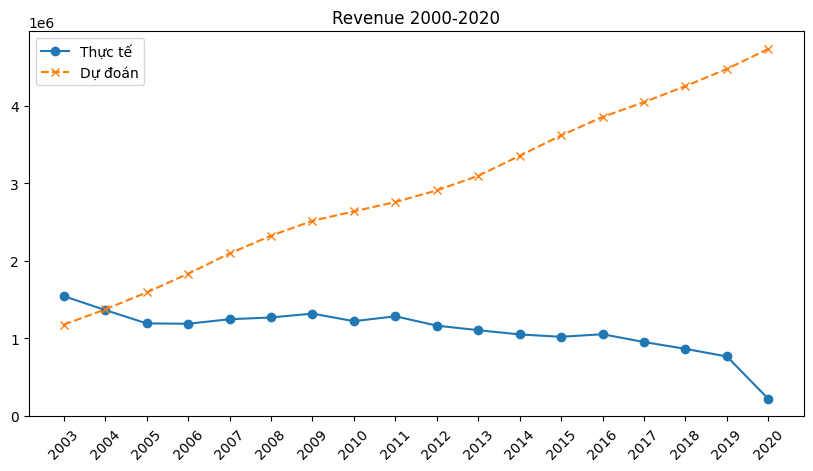

In [262]:
train_predict_evaluate_lstm(df_grouped_cleaned, look_back=3, epochs=50)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


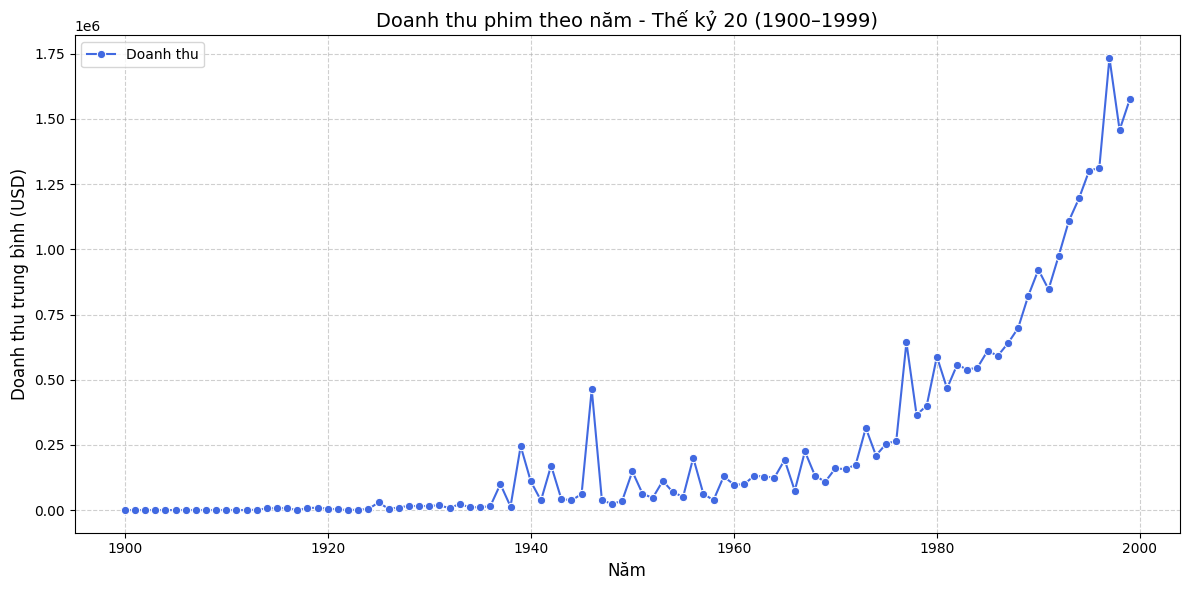

In [264]:
def plot_revenue_20th_century(df_grouped):
    # Lọc dữ liệu thế kỷ 20 (1900–1999)
    df_20th = df_grouped[(df_grouped['year'] >= 1900) & (df_grouped['year'] <= 1999)]

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_20th, x='year', y='revenue', marker='o', color='royalblue', label='Doanh thu')
    plt.title('Doanh thu phim theo năm - Thế kỷ 20 (1900–1999)', fontsize=14)
    plt.xlabel('Năm', fontsize=12)
    plt.ylabel('Doanh thu trung bình (USD)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Gọi hàm
plot_revenue_20th_century(df_grouped)